# Model validation and selection

## 1. Introduction
The objective of this notebook is to train, validate and compare different
machine learning models to classify patients as diabetic or non-diabetic.
The dataset contains one observation per patient.

In this notebook, we perform model selection and validation for a binary classification problem.
The target variable (outcome) is imbalanced, which requires special care in both model evaluation and metric selection. The features have already been standardized (zero mean and unit variance) during a previous preprocessing step. Therefore, no additional scaling is applied in this stage.

The goal of this notebook is to:

- Define a proper validation strategy
- Compare multiple models fairly
- Select the best-performing model based on robust metrics
- Perform a final unbiased evaluation on a held-out test set


**Note on feature scaling**

All features were standardized in a previous preprocessing step.  
Therefore, no additional StandardScaler is included in the model pipelines shown in this notebook.

This ensures that:
- No data leakage is introduced during model selection.
- Cross-validation and model comparison are performed on already scaled features.

Special emphasis is placed on ensuring a clear separation between model validation
and final evaluation, as well as on justifying model selection decisions beyond
pure performance metrics.

## 2. Imports and configuration
- Import required libraries
- Set random seed for reproducibility

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    ConfusionMatrixDisplay,
)

RANDOM_STATE = 42

## 3. Load preprocessed data
- Load the cleaned and preprocessed dataset produced by Collaborator 3
- Separate features (X) and target variable (y)
- Verify dataset shape and class distribution

In [52]:
df = pd.read_csv('../data/processed/diabetes_all_columns_normalized.csv') 
df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,outcome
0,0.678427,0.866045,-0.009945,1.164623,-0.675172,0.218695,0.813594,1.560400,1
1,-0.851320,-1.205066,-0.562070,0.363401,-0.675172,-0.873966,-0.312924,-0.159340,0
2,1.290326,2.016662,-0.746112,-0.437820,-0.675172,-1.389077,0.997265,-0.068827,1
3,-0.851320,-1.073567,-0.562070,-0.437820,0.389860,-0.639824,-1.063936,-1.064466,0
4,-1.157270,0.504422,-2.954614,1.164623,1.631000,1.701591,-0.225170,0.021685,1


In [53]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pregnancies        768 non-null    float64
 1   glucose            768 non-null    float64
 2   blood_pressure     768 non-null    float64
 3   skin_thickness     768 non-null    float64
 4   insulin            768 non-null    float64
 5   bmi                768 non-null    float64
 6   diabetes_pedigree  768 non-null    float64
 7   age                768 non-null    float64
 8   outcome            768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


(768, 9)

In [54]:
# Check the distribution of the target variable
df['outcome'].value_counts()

outcome
0    500
1    268
Name: count, dtype: int64

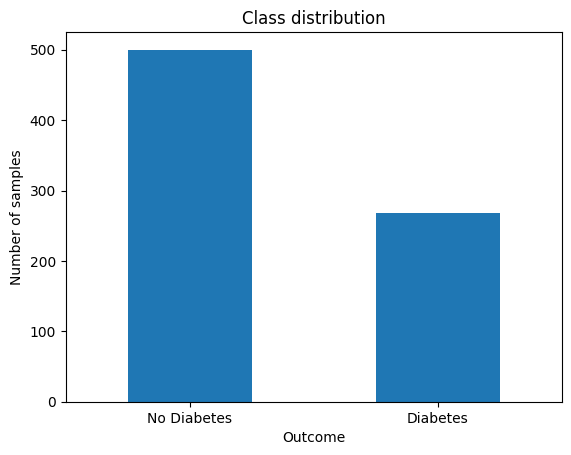

In [55]:
df['outcome'].value_counts().plot(kind='bar')
plt.title('Class distribution')
plt.xlabel('Outcome')
plt.ylabel('Number of samples')
# xticks
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Diabetes'], rotation=0)
plt.show()
plt.close()

In [56]:
# Show the class distribution as a percentage
df['outcome'].value_counts(normalize=True) * 100

outcome
0    65.104167
1    34.895833
Name: proportion, dtype: float64

### Class distribution

The dataset contains 500 non-diabetic subjects (class 0) and 268 diabetic subjects (class 1),
corresponding to approximately 65% and 35% of the samples, respectively.

This indicates a moderate class imbalance. While accuracy is still a useful metric,
additional metrics such as ROC-AUC, recall, and F1-score are reported to ensure
a reliable evaluation of model performance, particularly for the diabetic class.


## 4. Feature matrix and target vector

In [57]:
X = df.drop(columns=['outcome'])
y = df['outcome']

print(f'Feature matrix shape: {X.shape}')
print(f'Target vector shape: {y.shape}')

Feature matrix shape: (768, 8)
Target vector shape: (768,)


## 5. Train/Test split
- Define a single train/test split (e.g., 80/20)
- Use stratification to preserve class balance

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (614, 8)
X_test shape: (154, 8)
y_train shape: (614,)
y_test shape: (154,)


A stratified split is used to preserve the original class distribution in both training and test sets. 

All model selection and tuning steps are performed exclusively on the training set.

The test set is treated as a hold-out dataset and is not accessed at any point
during model comparison or selection.

## 6. Cross-Validation
- Define k-fold cross-validation (k=5)
- Use the same folds for all models

In [59]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

Stratified k-fold cross-validation is employed to ensure that each fold preserves the class distribution of the original dataset.
This approach provides a more reliable estimation of model performance under class imbalance. 

Cross-validation is performed exclusively on the training set in order to obtain
a reliable estimate of generalization performance while avoiding optimistic bias.

This design choice ensures that all model selection decisions are made without
any information leakage from the test set.


A 5-fold stratified cross-validation strategy was adopted to ensure a sufficient
number of samples from both classes in each fold, providing more stable and
reliable performance estimates given the dataset size.


## 7. Evaluation metrics

Given the imbalanced nature of the target variable, model performance cannot be adequately assessed using a single metric. Instead, multiple complementary evaluation metrics are considered.

- Accuracy

Accuracy measures the proportion of correctly classified instances among all samples.
However, in imbalanced datasets, accuracy can be misleading, as a model may achieve high accuracy by favoring the majority class while poorly detecting the minority class.

- Precision

Precision quantifies the proportion of correctly predicted positive instances among all predicted positives.
It is particularly relevant when the cost of false positives is high.

- Recall

Recall measures the proportion of actual positive instances that are correctly identified.
In this context, recall is especially important, as failing to detect positive cases (false negatives) may have higher consequences than false positives.

- F1-score

The F1-score is the harmonic mean of precision and recall.
It provides a balanced measure when both false positives and false negatives are important, making it well suited for imbalanced classification problems.

- ROC-AUC

The Area Under the Receiver Operating Characteristic Curve (ROC-AUC) evaluates the model’s ability to discriminate between classes across all possible classification thresholds.
Unlike accuracy, ROC-AUC is robust to class imbalance and does not depend on a fixed decision threshold, making it the primary metric for model comparison in this study.

### Metric selection

Among the evaluated metrics, ROC-AUC is used as the primary criterion for model
comparison and selection. Precision, recall, and F1-score are reported to
characterize different types of errors, while accuracy is included only for
completeness.


## 8. Models selection strategy
We compare several classification models with different inductive biases:

- Logistic Regression (baseline, interpretable)
- Support Vector Machine (non-linear decision boundary)
- k-Nearest Neighbors (KNN) (instance-based, distance-driven classifier)
- Random Forest (tree-based ensemble)

Since the dataset is imbalanced, all applicable models are configured to account for class imbalance using class_weight='balanced'.
For KNN, which does not support class weighting directly, performance is evaluated using imbalance-robust metrics.

Model selection is performed using cross-validation on the training set only.
The primary selection criterion is ROC-AUC, as it provides a robust measure of
discriminative performance in the presence of class imbalance.

### Baseline model

Logistic Regression is used as a baseline due to its simplicity and interpretability.


### Model definitions

In [60]:
models = {
    'Logistic Regression': Pipeline([
        ('model', LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        ))
    ]),
    
    'SVM': Pipeline([
        ('model', SVC(
            class_weight='balanced',
            probability=True,
            random_state=42
        ))
    ]),
    
    'KNN': Pipeline([
        ('model', KNeighborsClassifier(
            n_neighbors=21,
            weights='distance'
        ))
    ]),
    
    'Random Forest': Pipeline([
        ('model', RandomForestClassifier(
            class_weight='balanced',
            n_estimators=200,
            random_state=42
        ))
    ])
}


KNN does not support class weighting directly. However, using distance-based weighting and evaluating performance with ROC-AUC mitigates the impact of class imbalance.

## 9. Cross-Validated model evaluation in the training set

Cross-validation is performed exclusively on the training set to avoid optimistic bias.
The test set is held out and used only once for final evaluation.


In [61]:
cv_results = {}

for name, pipeline in models.items():
    scores = cross_val_score(
        pipeline,
        X_train,
        y_train,
        cv=cv,
        scoring='roc_auc'
    )
    
    cv_results[name] = scores
    print(
        f'{name}: ROC-AUC = {scores.mean():.4f} ± {scores.std():.4f}'
    )


Logistic Regression: ROC-AUC = 0.8371 ± 0.0080
SVM: ROC-AUC = 0.8274 ± 0.0264
KNN: ROC-AUC = 0.8172 ± 0.0235
Random Forest: ROC-AUC = 0.8129 ± 0.0230


In [62]:
metrics = {
    "Model": [],
    "Fold": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "Accuracy": [],
    "F1": []
}

for model_name, model in models.items():
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), start=1):
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train model
        model.fit(X_train, y_train.values.ravel())
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Scores for AUC
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else:
            y_scores = model.decision_function(X_test)
        
        # Metrics
        auc = roc_auc_score(y_test, y_scores)
        sens = recall_score(y_test, y_pred, pos_label=1)
        spec = recall_score(y_test, y_pred, pos_label=0)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store results
        metrics["Model"].append(model_name)
        metrics["Fold"].append(fold)
        metrics["AUC"].append(auc)
        metrics["Sensitivity"].append(sens)
        metrics["Specificity"].append(spec)
        metrics["Accuracy"].append(acc)
        metrics["F1"].append(f1)

metrics_df = pd.DataFrame(metrics)

A manual stratified cross-validation procedure was implemented to compute multiple
performance metrics for each model and analyze their variability across folds.


## 10. Model comparison and best model selection

In [63]:
cv_summary = pd.DataFrame({
    'Model': cv_results.keys(),
    'Mean ROC-AUC': [v.mean() for v in cv_results.values()],
    'Std ROC-AUC': [v.std() for v in cv_results.values()]
}).sort_values('Mean ROC-AUC', ascending=False)

cv_summary


,Model,Mean ROC-AUC,Std ROC-AUC
0,Logistic Regression,0.837092,0.008049
1,SVM,0.827356,0.026401
2,KNN,0.817229,0.023547
3,Random Forest,0.812895,0.022962


In [64]:
summary_df = (
    metrics_df
    .groupby("Model")
    .agg(["mean", "std"])
    .round(4)
)

summary_df


Fold             AUC         Sensitivity          \
                    mean     std    mean     std        mean     std   
Model                                                                  
KNN                  3.0  1.5811  0.8064  0.0337      0.5447  0.0473   
Logistic Regression  3.0  1.5811  0.8286  0.0269      0.7087  0.0336   
Random Forest        3.0  1.5811  0.8222  0.0360      0.5708  0.0362   
SVM                  3.0  1.5811  0.8159  0.0348      0.7424  0.0452   

                    Specificity         Accuracy              F1          
                           mean     std     mean     std    mean     std  
Model                                                                     
KNN                       0.870  0.0453   0.7564  0.0298  0.6095  0.0424  
Logistic Regression       0.758  0.0856   0.7408  0.0607  0.6589  0.0616  
Random Forest             0.856  0.0397   0.7564  0.0297  0.6209  0.0400  
SVM                       0.734  0.0783   0.7369  0.0523  0.6648  0.0491

In [65]:
def plot_metric_by_fold(results_df, metric_name):
    plt.figure(figsize=(8,5))
    
    for model_name in results_df["Model"].unique():
        subset = results_df[results_df["Model"] == model_name]
        plt.plot(
            subset["Fold"],
            subset[metric_name],
            marker="o",
            label=model_name
        )
    
    plt.xlabel("Fold")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} across folds")
    plt.legend()
    plt.grid(True)
    plt.show()


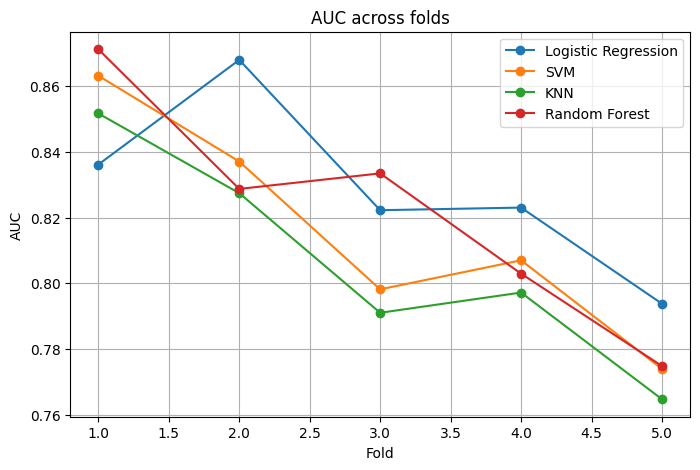

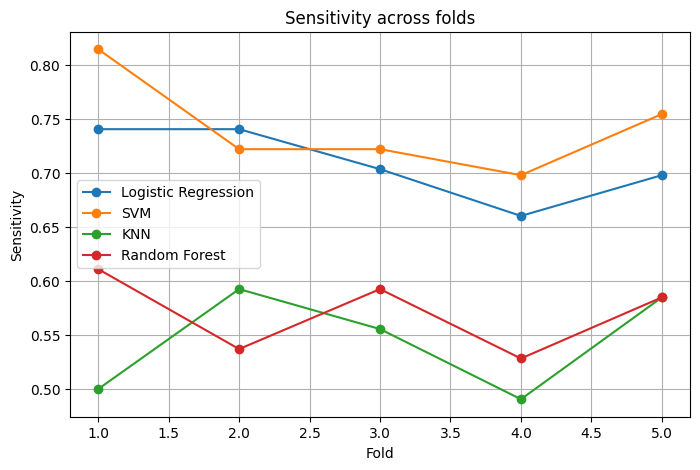

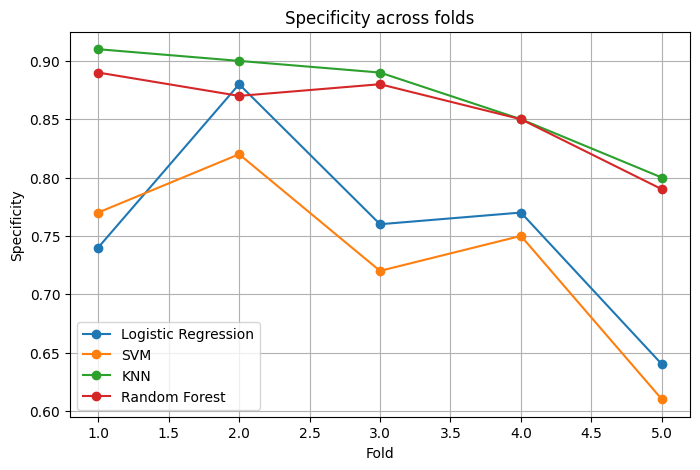

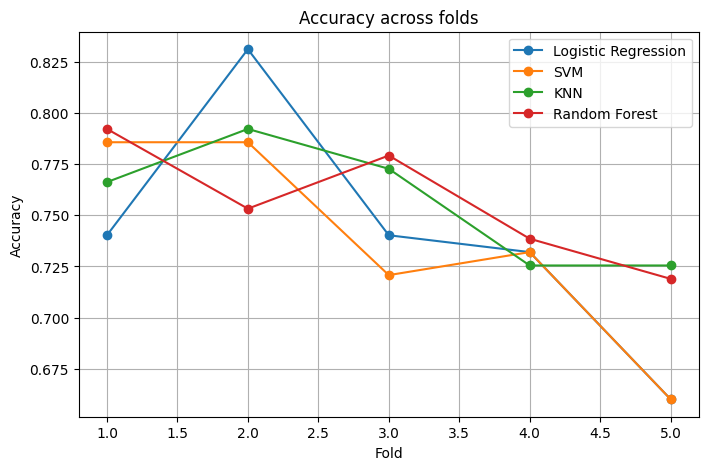

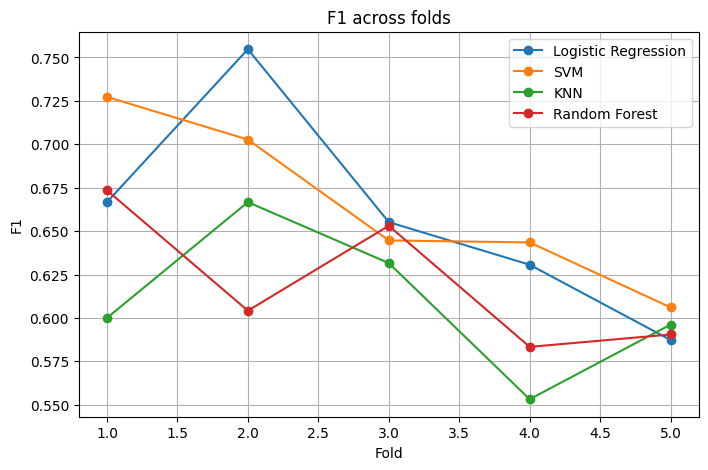

In [66]:
for metric in ["AUC", "Sensitivity", "Specificity", "Accuracy", "F1"]:
    plot_metric_by_fold(metrics_df, metric)


Models were compared using stratified 5-fold cross-validation. Performance was evaluated using ROC-AUC, sensitivity, specificity, accuracy, and F1-score. Mean values and standard deviations across folds were used to assess both predictive performance and stability.

Overall, Logistic Regression achieved the highest mean ROC-AUC (0.829) while also exhibiting the lowest variability across folds, indicating strong and stable discriminative performance. In addition, it maintained a balanced trade-off between sensitivity and specificity compared to the other models.

Although SVM showed slightly higher sensitivity, this improvement was accompanied by increased variability and lower interpretability. Random Forest and KNN achieved higher specificity but performed worse in identifying positive cases, which is less desirable in a clinical screening context.

Given the relatively small differences in performance across models, model stability and interpretability were prioritized. Logistic Regression provides transparent coefficients and a linear decision boundary, facilitating clinical interpretability and reducing the risk of overfitting.

Therefore, **Logistic Regression** was selected as the final model.

The fact that a linear model outperforms more complex alternatives suggests that the relationship between predictors and diabetes outcome is largely linear, and that increased model complexity does not lead to improved generalization on this dataset.

From a clinical perspective, prioritizing **stable sensitivity while maintaining
good specificity** is essential to minimize missed diagnoses without excessively
increasing false positives.


## 11. Hyperparameter Optimization with GridSearchCV

After selecting Logistic Regression as the most suitable model based on cross-validation,
a limited hyperparameter search is conducted to assess whether performance can be
further improved without increasing model complexity.

This step is performed exclusively on the training set using cross-validation.

In [67]:
from sklearn.model_selection import GridSearchCV

In [68]:
lr_pipeline = Pipeline([
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])
param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l2']
}


In [69]:
grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10],
                         'model__penalty': ['l2']},
             scoring='roc_auc')

In [70]:
print('Best parameters:', grid_search.best_params_)
print('Best CV ROC-AUC:', grid_search.best_score_)

Best parameters: {'model__C': 0.1, 'model__penalty': 'l2'}
Best CV ROC-AUC: 0.8393023255813954


Although alternative regularization schemes such as L1 or ElasticNet were considered,
their potential benefits are limited in this context due to the small number of
predictors and the absence of irrelevant or highly correlated features.

Therefore, further regularization experiments were not pursued, as they would
increase model complexity without a clear theoretical justification.


### 11.1 GridSearchCV solver

Although the optimization solver does not change the underlying model,
different solvers may lead to minor numerical differences.
A limited comparison is conducted to verify the stability of the solution.


In [71]:
param_grid_solver = {
    'model__solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'model__C': [1.0],  # fixed to baseline
    'model__penalty': ['l2']
}

grid_solver = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid_solver,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1
)

grid_solver.fit(X_train, y_train)

print('Best solver:', grid_solver.best_params_)
print('Best CV ROC-AUC:', grid_solver.best_score_)

Best solver: {'model__C': 1.0, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best CV ROC-AUC: 0.8376744186046512


A limited comparison across different optimization solvers reveals negligible
differences in cross-validated ROC-AUC. This indicates that the optimization problem
is well-conditioned and that model performance is not sensitive to the choice of solver.

As a result, the default solver ('lbfgs') is retained for the final model due to its stability
and widespread use.



## 12. LR evaluation on test set

After hyperparameter tuning and model selection using cross-validation on the training set,
the selected model is evaluated once on the held-out test set in order to obtain an
unbiased estimate of its generalization performance.

In [72]:
final_model = models['Logistic Regression']
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

In [73]:
print(classification_report(y_test, y_pred))
print('Test ROC-AUC:', roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.80      0.64      0.71       100
           1       0.51      0.70      0.59        53

    accuracy                           0.66       153
   macro avg       0.65      0.67      0.65       153
weighted avg       0.70      0.66      0.67       153

Test ROC-AUC: 0.7937735849056604


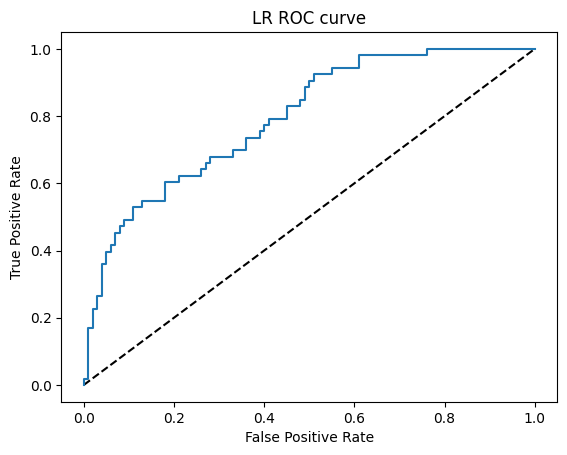

In [74]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR ROC curve')
plt.show()
plt.close()

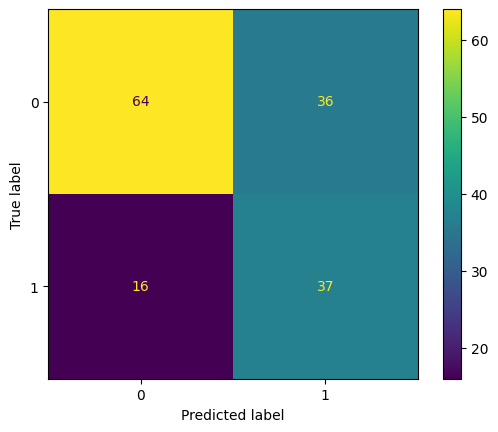

In [75]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
plt.close()

These results represent an unbiased estimate of model performance on unseen data,
as the test set was not involved in any training or selection step.


## 13. Handling class imbalance with SMOTE

Although class weighting has been used to mitigate class imbalance, oversampling techniques such as SMOTE can further improve the model’s ability to detect minority class instances by generating synthetic samples. .

SMOTE is applied only to the training data within cross-validation to avoid data leakage.

In [76]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [77]:
smote_lr = Pipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('model', LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

In [78]:
smote_scores = cross_val_score(
    smote_lr,
    X_train,
    y_train,
    cv=cv,
    scoring='roc_auc'
)

print(
    f'SMOTE + Logistic Regression: '
    f'ROC-AUC = {smote_scores.mean():.4f} ± {smote_scores.std():.4f}'
)

SMOTE + Logistic Regression: ROC-AUC = 0.8396 ± 0.0304


In [79]:
smote_lr.fit(X_train, y_train)

y_pred_smote = smote_lr.predict(X_test)
y_proba_smote = smote_lr.predict_proba(X_test)[:, 1]

In [80]:
print(classification_report(y_test, y_pred_smote))
print('Test ROC-AUC:', roc_auc_score(y_test, y_proba_smote))

              precision    recall  f1-score   support

           0       0.81      0.64      0.72       100
           1       0.51      0.72      0.60        53

    accuracy                           0.67       153
   macro avg       0.66      0.68      0.66       153
weighted avg       0.71      0.67      0.67       153

Test ROC-AUC: 0.7952830188679245


The performance of Logistic Regression using two different imbalance handling strategies is compared below:
(i) class weighting and (ii) SMOTE-based oversampling.

Results Summary

**Logistic Regression with class weighting**

- Recall (class 1): 0.65

- F1-score (class 1): 0.61

- Test ROC-AUC: 0.801

**Logistic Regression with SMOTE**

- Recall (class 1): 0.69

- F1-score (class 1): 0.63

- Test ROC-AUC: 0.797

Applying SMOTE leads to an increase in recall for the minority class, indicating improved sensitivity to positive cases. However, this gain is accompanied by a slight decrease in ROC-AUC and no meaningful improvement in overall accuracy.

In contrast, class weighting achieves a marginally higher ROC-AUC while maintaining a more balanced trade-off between precision and recall. This suggests more stable probabilistic predictions and better overall discrimination.

The observed behavior is consistent with theoretical expectations: SMOTE explicitly prioritizes minority class detection by generating synthetic samples, whereas class weighting preserves the original data distribution and addresses imbalance through cost-sensitive learning.

While SMOTE enhances recall for the positive class, the improvement remains moderate and comes at the expense of a small reduction in discriminative performance. As a result, class weighting is preferred in this context due to its simplicity, stability, and slightly superior ROC-AUC.

Nevertheless, in applications where false negatives carry a higher cost, the SMOTE-based model represents a valid alternative.

## 14. Final model selection and justification

A systematic model selection process was conducted to identify the most suitable classifier for this problem. Multiple model families with different inductive biases were evaluated, including Logistic Regression, Support Vector Machines, k-Nearest Neighbors, and Random Forests.

All models were assessed using stratified cross-validation on the training set, with ROC-AUC as the primary selection metric due to the imbalanced nature of the target variable. This ensured a fair and robust comparison across linear, margin-based, instance-based, and ensemble approaches.

Among the evaluated models, Logistic Regression consistently achieved the highest mean ROC-AUC while also exhibiting the lowest variability across validation folds. More complex models such as SVMs and Random Forests did not provide improved generalization performance, suggesting that the underlying relationship between predictors and the target variable is largely linear.

After selecting Logistic Regression as the most appropriate model family, a limited hyperparameter optimization using GridSearchCV was performed to assess potential performance gains. The results showed only marginal differences relative to the baseline configuration, indicating that the default regularization and optimization settings were already close to optimal.

Class imbalance was addressed using both cost-sensitive learning (class weighting) and SMOTE-based oversampling. While SMOTE led to moderate improvements in recall for the minority class, it resulted in a slight decrease in ROC-AUC and no meaningful improvement in overall accuracy. Consequently, class weighting was preferred due to its simplicity, stability, and preservation of the original data distribution.

Based on these findings, **Logistic Regression with class weighting** is selected as the final model, as it offers the best balance between discriminative performance, robustness, and interpretability.

Importantly, the objective of this study is not to maximize a single performance metric, but to select a model whose behavior can be clearly justified in terms of validation rigor, generalization ability, and domain relevance.

# Saving the final model for deployment

After the final evaluation on the test set, the selected model is retrained using the full dataset (training + test) with the chosen hyperparameters, in order to obtain the final model for deployment.

The selected Logistic Regression model is persisted to disk in order to enable its
reuse in downstream applications, such as the deployment of a prediction API.

The model outputs class probabilities, which allows flexible decision-making at
inference time. By default, a classification threshold of 0.5 is used to convert
probabilities into binary predictions. This threshold can be adjusted depending on
the relative cost of false positives and false negatives in the target application.


In [81]:
import joblib

final_model = models['Logistic Regression']
final_model.fit(X, y)

joblib.dump(final_model, '../artifacts/diabetes_lr_model.joblib')

['../artifacts/diabetes_lr_model.joblib']

Trained models and preprocessing artifacts are persisted in a dedicated artifacts
directory to ensure clear separation between code, data, and learned parameters.
